# Template fits

In applications we are interested in separating a signal component from background components, we often fit parameteric models to data. Sometimes constructing a parametric model for some component is difficult. In that case, one fits a template instead which may be obtained from simulation or from a calibration sample in which a pure component can be isolated.

The challenge then is to propagate the uncertainty of the template into the result. The template is now also estimated from a sample (be it simulated or a calibration sample), and the uncertainty associated to that can be substantial. We investigate different approaches for template fits, including the Barlow-Beeston and Barlow-Beeston-lite methods.

In [1]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, BarlowBeestonLite, ExtendedBinnedNLL
import numpy as np
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict
from joblib import Parallel, delayed

As a toy example, we generate a mixture of two components: a normally distributed signal and exponentially distributed background.

In [2]:
def generate(rng, nmc, truth, bins):
    xe = np.linspace(0, 2, bins + 1)
    b = np.diff(truncexpon(1, 0, 2).cdf(xe))
    s = np.diff(norm(1, 0.1).cdf(xe))
    n = rng.poisson(b * truth[0]) + rng.poisson(s * truth[1])
    t = np.array([rng.poisson(b * nmc), rng.poisson(s * nmc)])
    return xe, n, t

rng = np.random.default_rng(1)
truth = 750, 250
xe, n, t = generate(rng, 100, truth, 15)

Data is visualized on the left-hand side. The templates are shown on the right-hand side. To show the effect of uncertainties in the template, this example intentially uses templates with poor statistical resolution.

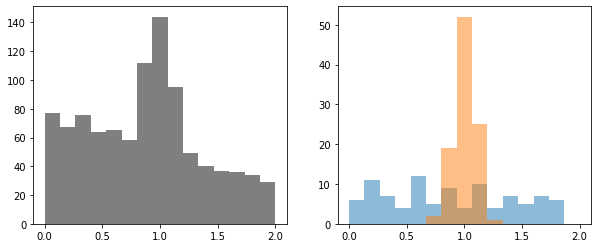

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax[0].stairs(n, xe, fill=True, color="k", alpha=0.5, label="data")
for i, ti in enumerate(t):
    ax[1].stairs(ti, xe, fill=True, alpha=0.5, label=f"template {i}")

## Bootstrapping template uncertainties

Bootstrapping is a general purpose technique to include uncertainties backed up by bootstrap theory, so it can be applied to this problem.
We perform a standard fit and pretend that the templates have no uncertainties. Then, we repeat this fit many times with templates that are fluctuated around the actual values assuming a Poisson distribution.

There is no built-in cost function in iminuit for a template fit, so we write the cost function for this case.

In [4]:
def cost(yields):
    mu = 0
    for y, c in zip(yields, t):
        mu += y * c / np.sum(c)
    r = poisson_chi2(n, mu)
    return r

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(n.shape)

starts = np.ones(2)
m = Minuit(cost, starts)
m.limits = (0, None)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.338e+04 (chi2/ndof = 3336.6)│              Nfcn = 110              │
│ EDM = 3.77e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    761    │    30     │            │            │    0    │         │       │
│ 1 │ x1   │    193    │    19     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────┐
│    │   x0   x1 │
├────┼───────────┤
│ x0 │  933 -172 │
│ x1 │ -172  365 │
└────┴───────────┘

The uncertainties reported by the fit correspond to the uncertainty in the data, but not the uncertainty in the templates. The chi2/ndof is also very large, since the uncertainties in the template are not considered in the fit.

We bootstrap the templates 1000 times and compute the covariance of the fitted results.

In [5]:
b = 1000
rng = np.random.default_rng(1)
pars = []
for ib in range(b):
    ti = rng.poisson(t)

    def cost(yields):
        mu = 0
        for y, c in zip(yields, ti):
            mu += y * c / np.sum(c)
        r = poisson_chi2(n, mu)
        return r
    
    mi = Minuit(cost, m.values[:])
    mi.errordef = Minuit.LEAST_SQUARES
    mi.limits = (0, None)
    mi.strategy = 0
    mi.migrad()
    assert mi.valid
    pars.append(mi.values[:])

cov2 = np.cov(np.transpose(pars), ddof=1)

We print the uncertainties from the different stages and the correlation between the two yields.

To obtain the full error, we add the independent covariance matrices from the original fit and the bootstrap.

In [6]:
cov1 = m.covariance

for title, cov in zip(("fit", "bootstrap", "fit+bootstrap"), 
                      (cov1, cov2, cov1 + cov2)):
    print(title)
    for label, p, e in zip(("b", "s"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / np.prod(np.diag(cov)) ** 0.5:.2f}")

fit
  b 761 +- 31
  s 193 +- 19
  correlation -0.29
bootstrap
  b 761 +- 36
  s 193 +- 35
  correlation -0.96
fit+bootstrap
  b 761 +- 48
  s 193 +- 39
  correlation -0.73


The bootstrapped template errors are much larger than the fit errors in this case, since the sample used to generate the templates is much smaller than the data sample.

The bootstrapped errors for both yields are nearly equal (they become exactly equal if the template sample is large) and the correlation is close to -1 (and becomes exactly -1 in large samples). This is expected, since the data sample is fixed in each iteration. Under these conditions, a change in the templates can only increase the yield of one component at an equal loss for the other component.

## Template fit with nuisance parameters

As described in [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W), the correct treatment from first principles is to write down the likelihood function for this case, in which the observed values and unknown parameters are clearly stated. The insight is that the true contents of the bins for the templates are unknown and we need to introduce a nuisance parameter for each bin entry in the template. The combined likelihood for the problem is then combines the estimation of the template yields with the estimation of unknown templates.

This problem can be handled straight-forwardly with Minuit, but it leads to the introduction of a large number of nuisance parameters, one for each entry in each template. We again write a cost function for this case (here a class for convenience).

As a technical detail, it is necessary to increase the call limit in Migrad for the fit to fully converge, since the limit set by Minuit's default heuristic is too tight for this application.

In [7]:
class BB:
    def __init__(self, n, t):
        self.data = n, t

    def __call__(self, par):
        n, t = self.data
        bins = len(n)
        yields = par[:2]
        nuisances = par[2:]
        b = nuisances[:bins]
        s = nuisances[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * c / np.sum(c)
        r = poisson_chi2(n, mu) + poisson_chi2(t[0], b) + poisson_chi2(t[1], s)
        return r

    @property
    def ndata(self):
        n, t = self.data
        return np.prod(n.shape) + np.prod(t.shape)

m1 = Minuit(BB(n, t), np.concatenate([truth, t[0], t[1]]))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.27 (chi2/ndof = 1.4)    │             Nfcn = 3464              │
│ EDM = 6.02e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    800    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
│ 2 │ x2   │    9.0    │    1.4    │            │            │    0    │         │       │
│ 3 │ x3   │    8.5    │    1.3    │            │            │    0    │         │       │
│ 4 │ x4   │    9.0    │    1.4    │            │            │    0    │         │       │
│ 5 │ x5   │    7.4    │    1.2    │            │            │    0    │         │       │
│ 6 │ x6   │    8.4    │    1.3    │            │            │    0    │         │       │
│ 7 │ x7   │    6.4    │    1.1    │            │            │    0    │         │       │
│ 8 │ x8   │    9.2    │    1.7    │            │            │    0    │         │       │
│ 9 │ x9   │    4.8    │    2.3    │            │            │    0    │         │       │
│ 10│ x10  │    7.0    │    1.5    │            │            │    0    │         │       │
│ 11│ x11  │    5.5    │    1.0    │            │            │    0    │         │       │
│ 12│ x12  │    5.1    │    0.9    │            │            │    0    │         │       │
│ 13│ x13  │    4.6    │    0.9    │            │            │    0    │         │       │
│ 14│ x14  │    4.7    │    0.9    │            │            │    0    │         │       │
│ 15│ x15  │    4.3    │    0.8    │            │            │    0    │         │       │
│ 16│ x16  │    3.2    │    0.7    │            │            │    0    │         │       │
│ 17│ x17  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 18│ x18  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 19│ x19  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 20│ x20  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 21│ x21  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 22│ x22  │    2.1    │    1.5    │            │            │    0    │         │       │
│ 23│ x23  │    19     │     4     │            │            │    0    │         │       │
│ 24│ x24  │    54     │     7     │            │            │    0    │         │       │
│ 25│ x25  │    23     │     4     │            │            │    0    │         │       │
│ 26│ x26  │    1.1    │    1.0    │            │            │    0    │         │       │
│ 27│ x27  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 28│ x28  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 29│ x29  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 30│ x30  │    0.0    │    0.4    │            │            │    0    │         │   

The result of this fit is comparable to the bootstrap method for this example, but the chi2/ndof is now reasonable and the uncertainties are correct without further work. This method should perform better than the bootstrap method, if the count per bin in the templates is small.

Another advantage is of this technique is that one can profile over the likelihood to obtain a 2D confidence regions, which is not possible with the bootstrap technique.

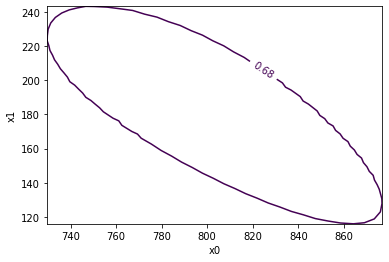

In [8]:
m1.draw_mncontour("x0", "x1");

Before moving on, we briefly explore a possible refinement of the previous method, which is to hide the nuisance parameters from Minuit with a nested fit. It turns out that this technique is not an improvement, but it is useful to show that explicitly.

The idea is to construct an outer cost function, which only has the yields as parameters. Inside the outer cost function, the best nuisance parameters are found for the current yields with an inner cost function. Technically, this is achieved by calling a minimizer on the inner cost function at every call to the outer cost function.

Technical detail: It is important here to adjust Minuit's expectation of how accurate the cost function is computed. Usually, Minuit performs its internal calculations under the assumption that the cost function is accurate to machine precision. This is usually not the case when a minimizer is used internally to optimize the inner function. We perform the internal minimization with SciPy, which allows us to set the tolerance. We set it here to 1e-8, which is sufficient for this problem and saves a bit of time on the internal minimisation. We then instruct Minuit to expect only this precision.

In [9]:
precision = 1e-8

def cost(yields):
    bins = len(n)

    def inner(nuisance):
        b = nuisance[:bins]
        s = nuisance[bins:]
        mu = 0
        for y, c in zip(yields, (b, s)):
            mu += y * c / np.sum(c)
        r = poisson_chi2(n, mu) + poisson_chi2(t[0], b) + poisson_chi2(t[1], s)
        return r

    bounds = np.zeros((2 * bins, 2))
    bounds[:, 1] = np.inf
    r = minimize(inner, np.ravel(t), bounds=bounds, tol=precision)
    assert r.success
    return r.fun

cost.errordef = Minuit.LEAST_SQUARES
cost.ndata = np.prod(n.shape)

m2 = Minuit(cost, truth)
m2.precision = precision
m2.limits = (0, None)
m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.27 (chi2/ndof = 1.4)    │              Nfcn = 60               │
│ EDM = 1.23e-08 (Goal: 0.0002)    │            time = 7.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    800    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  2.22e+03 -1.43e+03 │
│ x1 │ -1.43e+03  1.62e+03 │
└────┴─────────────────────┘

We obtain the exact same result as expected, but the runtime is much longer (more than a factor 10), which disfavors this technique compared to the straight-forward fit. The minimization is not as efficient, because Minuit cannot exploit correlations between the internal and the external parameters that allow it to converge it faster when it sees all parameters at once.

## Barlow-Beeston-lite

The implementation described by [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W) solves the problem similarly to the nested fit described above, but the solution to the inner problem is found with a more efficient algorithm. Unfortunately, their approach still requires numerically solving a non-linear equation per bin. The finite accuracy of the non-linear solver introduces discontinuities in the log-likelihood that confuse Minuit, as noted by [Conway, PHYSTAT 2011, https://arxiv.org/abs/1103.0354](https://doi.org/10.48550/arXiv.1103.0354). To address this, Conway proposes a simplified treatment where the uncertainty in the template is described by a multiplicative factor constrained by a Gaussian. With this simplification, the optimal nuisance parameters can be found by bin-by-bin by solving a quadratic equation which has only one allowed solution that can be found analytically. Conway's method and an improved approximate method derived in [Dembinski, https://arxiv.org/abs/2206.12346](https://doi.org/10.48550/arXiv.2206.12346) are implemented in the built-in BarlowBeestonLite cost function.

In [10]:
c = BarlowBeestonLite(n, xe, t, method="jsc") # Conway
m3 = Minuit(c, *truth)
m3.limits = (0, None)
m3.migrad()
m3.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.52 (chi2/ndof = 0.9)    │              Nfcn = 48               │
│ EDM = 6.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.86e3   │  0.11e3   │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  1.16e+04 -1.56e+03 │
│ x1 │ -1.56e+03  1.94e+03 │
└────┴─────────────────────┘

In [11]:
c = BarlowBeestonLite(n, xe, t, method="hpd") # Dembinski
m4 = Minuit(c, *truth)
m4.limits = (0, None)
m4.migrad()
m4.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.42 (chi2/ndof = 0.9)    │              Nfcn = 47               │
│ EDM = 1.85e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    760    │    90     │            │            │    0    │         │       │
│ 1 │ x1   │    190    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  8.08e+03 -1.26e+03 │
│ x1 │ -1.26e+03  1.81e+03 │
└────┴─────────────────────┘

In [12]:
for title, m in zip(("full fit", "BBL-JSC", "BBL-HPD"), (m1, m3, m4)):
    print(title)
    cov = m.covariance
    for label, p, e in zip(("x0", "x1"), m.values, np.diag(cov) ** 0.5):
        print(f"  {label} {p:.0f} +- {e:.0f}")
    print(f"  correlation {cov[0, 1] / (cov[0, 0] * cov[1, 1]) ** 0.5:.2f}")

full fit
  x0 796 +- 47
  x1 187 +- 40
  correlation -0.76
BBL-JSC
  x0 858 +- 108
  x1 185 +- 44
  correlation -0.33
BBL-HPD
  x0 762 +- 90
  x1 194 +- 43
  correlation -0.33


The best yields found by the Barlow-Beeston-Lite (BBL) method differ from those found with the Barlow-Beeston (BB) method, because the two likelihoods are rather different. In this particular case, the uncertainty for the signal estimated by the BBL is larger. The difference shows up in particular in the 68 % confidence regions.

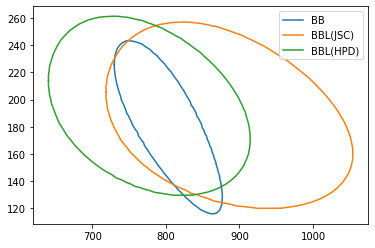

In [13]:
c1 = m1.mncontour("x0", "x1")
c3 = m3.mncontour("x0", "x1")
c4 = m4.mncontour("x0", "x1")
c1 = np.append(c1, [c1[0]], axis=0)
c3 = np.append(c3, [c3[0]], axis=0)
c4 = np.append(c4, [c4[0]], axis=0)
plt.plot(c1[:,0], c1[:, 1], label="BB")
plt.plot(c3[:,0], c3[:, 1], label="BBL(JSC)")
plt.plot(c4[:,0], c4[:, 1], label="BBL(HPD)")
plt.legend();

The results obtained with the different Barlow-Beeston methods are similar but not identical.

## Bias of the estimate and the estimated variance

A single toy experiment cannot be used to judge the performance of these methods. We need to study the properties of these fits applied to sets of toy experiments, which allow us to measure the bias of the estimate itself and the bias of its variance estimate, which should reflect the true variance.

We run three sets of experiments, with increasing number of events sampled for the templates. We expect that all methods converge as the sample used to compute the templates grows, since this reduces their relative uncertainties. To judge the estimates, we compute the pull distribution of the estimated signal yield, where the pull is defined as
$$
z = (\hat s  - s)/ \hat V_s^{1/2},
$$
with true signal yield $s$, estimate $\hat s$, and the estimated variance $\hat V_s$ of $\hat s$. The performance of the method is indicated by the degree of agreement of the mean of $z$ with 0 and the standard deviation with 1. 

In [14]:
@delayed
def compute(seed, truth, nmc):
    rng = np.random.default_rng(seed)
    xe, n, t = generate(rng, nmc, truth, 15)
    accept = True
    result = []
    ma = False
    for ti in t:
        ma |= ti > 0
    m_bb = Minuit(BB(n[ma], t[:, ma]), np.concatenate([truth, *t[:, ma]]))
    m_bbl = Minuit(BarlowBeestonLite(n, xe, t, method="jsc"), *truth)
    m_bbl2 = Minuit(BarlowBeestonLite(n, xe, t, method="hpd"), *truth)
    for m in (m_bb, m_bbl, m_bbl2):
        m.limits = (0, None)
        # try hard to converge and get correct error estimates
        for iter in range(10):
            m.strategy = 0
            m.migrad(ncall=1000000, iterate=1)
            m.hesse()
            if m.valid and m.accurate:
                break
        if not m.valid or not m.accurate: # should never happen
            print(cost.__name__)
            display(m)
        accept &= m.valid
        result.append((m.values[0], m.values[1], m.covariance[0, 0], m.covariance[1, 1]))
    if accept:
        return result
    return None

results = {}
for nmc in (200, 1000, 10000):
    r = Parallel(-1, verbose=1)(compute(s, truth, nmc) for s in range(50))
    r = [_ for _ in r if _ is not None]
    results[nmc] = np.array(r)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


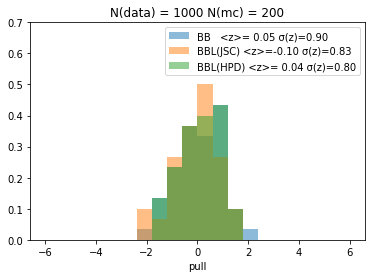

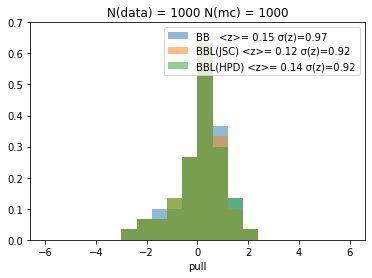

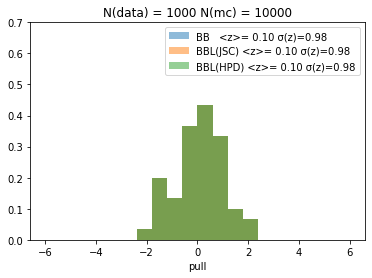

In [15]:
for nmc, r in results.items():
    plt.figure()
    for i, label in enumerate(("BB", "BBL(JSC)", "BBL(HPD)")):
        s = r[:, i, 1]
        vs = r[:, i, 3]
        z = (s - truth[1]) / vs ** 0.5
        plt.hist(z,
            label=(
                f"{label:4} "
                f"<z>={np.mean(z):5.2f} "
                f"σ(z)={np.std(z):.2f}"),
            density=True, alpha=0.5, bins=20, range=(-6, 6))
    plt.xlabel("pull")
    plt.title(f"N(data) = {np.sum(truth)} N(mc) = {nmc}")
    plt.ylim(0, 0.7)
    plt.legend();

The performance of the BBL methods is comparable to that of the BB method. In all cases, biases are small and the estimated variance is close to the actual variance. When the experiments are repeated with a high number of toy simulations, we find that the alternative BBL method performs slightly better than Conway's method.